### Volcano plots from Top3 proteomics data

- The notebook requires Top3 data from proteomics with individual replicates
- Originally designed for iterative upload of DBTL data (7 rounds)
    - Substitute with your own data of interest

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re
from adjustText import adjust_text
import os

#### Import Top3 data of interest

Load Top3 data from each of the DBTL cycles for analysis

In [2]:
input_dir = r'Figure_Data'
output_dir = r'Figure_Export'

In [3]:
# Incorporates all DBTL cycles
filenames = [f'DBTL{i}.csv' for i in range(7)]
input_paths = [os.path.join(input_dir, filename) for filename in filenames]

# Load CSVs and concatenate multiple files if necessary
dataframes = [pd.read_csv(input_path) for input_path in input_paths]
combined_df = pd.concat(dataframes, ignore_index=True)

Translate Top3 proteins into locus identities and then transform all of the uploaded concatenated .csvs

In [4]:
# Translation file between gene names
name_df = pd.read_csv(f'{input_dir}/proteomics_id_translator_240305.csv') 

# Create a dictionary from the name_df for fast lookup
translator_dict = pd.Series(name_df['locus'].values, index=name_df['extracted']).to_dict()

# Use the dictionary to map the Protein.Group names to locus names
combined_df['Protein.Group'] = combined_df['Protein.Group'].map(lambda x: translator_dict.get(x, x))

# Count the number of non-translated protein groups
nontranslated = combined_df['Protein.Group'].apply(lambda x: x not in translator_dict.values()).sum()
print(f"In total, N = {nontranslated}/{len(combined_df['Protein.Group'])} proteins were not translated to locus names")

In total, N = 19710/2532969 proteins were not translated to locus names


### Initialize a DataFrame to store log2 and log10 values for all samples

Include samples across all cycles to be analyzed

##### These will be compared against your "controls"

In [5]:
samples_of_interest = ["PP_5419","PP_1240","PP_1770"]

In [6]:
# samples_of_interest = [
#     "PP_0368",
#     "PP_0437",
#     "PP_0528",
#     "PP_0812",
#     "PP_0813",
#     "PP_0814",
#     "PP_0815",
#     "PP_1317",
#     "PP_1506",
#     "PP_2136",
#     "PP_4120",
#     "PP_4189",
#     "PP_4191",
#     "PP_4192"]

#### Define your controls
- Pairwise comparison of samples_of_interest to the defined controls pooled across all cycles

In [7]:
# Initialize an empty DataFrame to store log2 and log10 results
log2_log10_results = pd.DataFrame()
sample_control_pairs = {sample: "Control" for sample in samples_of_interest}

#### Set thresholds for the volcano plots 
- p-value threshold and log2 fold_change threshold
- filtering Top3 data 

In [8]:
# Define thresholds for filtering
# Use 1 if simply looking for any differences between a strain and a control
fold_change_threshold = 1.1
log2_fold_change_threshold= np.log2(fold_change_threshold)

p_value_threshold = 0.05
top3_filter = 0.01

### Generate volcano plots
- Sample pairs vs. control

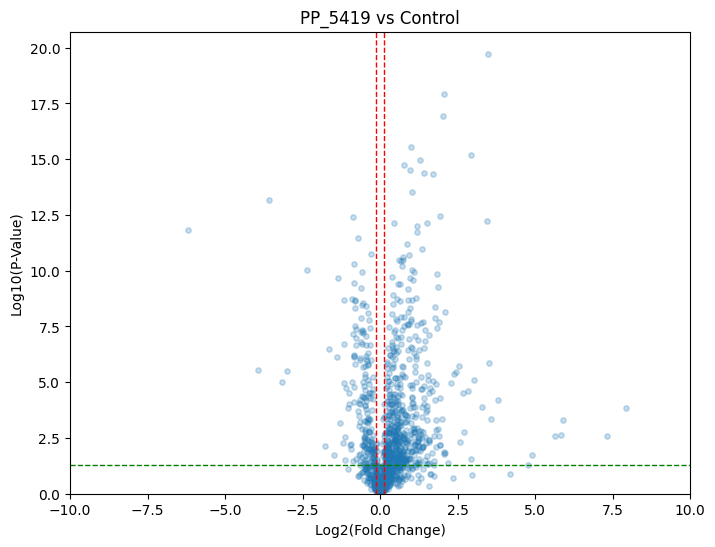

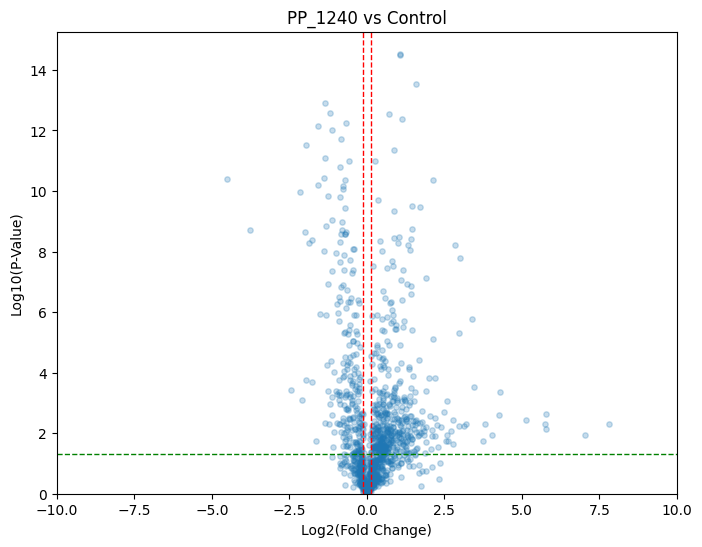

C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\Carruthers\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_stats_py.py:1113: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


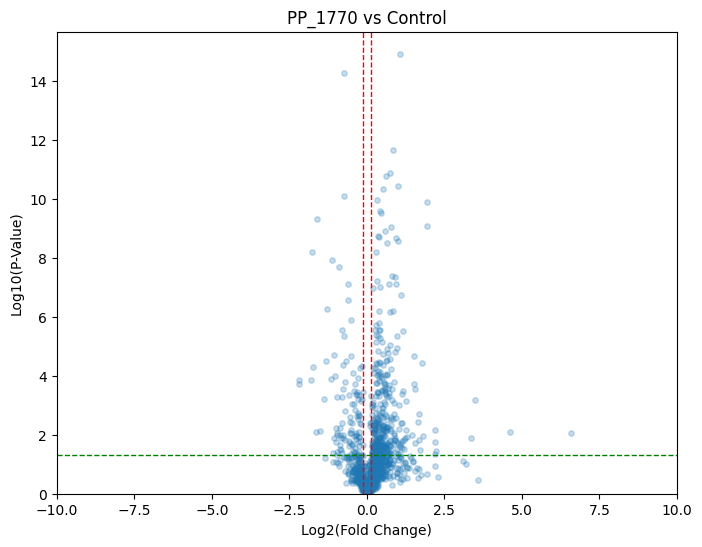

Log2 and Log10 values saved to 'Volcano_Results.csv'


In [9]:
# Initialize the results DataFrame before the loop
log2_log10_results = pd.DataFrame()
replicates_to_include = ['R4', 'R5', 'R6']

for sample, control in sample_control_pairs.items():
    # Filter data for the current sample and its control
    if sample in ['PP_0812', 'PP_0813']:
        sample_data = combined_df[(combined_df['Sample'] == sample) & (combined_df['Replicate'].isin(replicates_to_include))]
    else:
        sample_data = combined_df[combined_df['Sample'] == sample]
    
    control_data = combined_df[combined_df['Sample'] == control]

    # Debug: Check if data is loaded correctly
    if sample_data.empty or control_data.empty:
        print(f"No data for {sample} or {control}")
        continue

# for sample, control in sample_control_pairs.items():
#     sample_data = combined_df[combined_df['Sample'] == sample]
#     control_data = combined_df[combined_df['Sample'] == control]
#     # Debug: Check if data is loaded correctly
#     if sample_data.empty or control_data.empty:
#         print(f"No data for {sample} or {control}")
#         continue

    # Compute mean %_of protein_abundance_Top3-method for each protein
    sample_mean = sample_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()
    control_mean = control_data.groupby('Protein.Group')['%_of protein_abundance_Top3-method'].mean().reset_index()

    # Rename columns for clarity
    sample_mean.rename(columns={'%_of protein_abundance_Top3-method': 'sample_abundance'}, inplace=True)
    control_mean.rename(columns={'%_of protein_abundance_Top3-method': 'control_abundance'}, inplace=True)

    # Filter reference_mean to include only abundances > top3_filter
    sample_mean = sample_mean[sample_mean['sample_abundance'] > top3_filter]

    # Merge the data on Protein.Group
    merged_data = pd.merge(sample_mean, control_mean, on='Protein.Group', how='outer')

    # Calculate log2 fold change (fill missing values with NaN)
    merged_data['log2_change'] = np.log2(merged_data['sample_abundance'] / merged_data['control_abundance'])

    # Debug: Check if log2_change contains NaN values
    if merged_data['log2_change'].isna().all():
        print(f"All log2 fold changes are NaN for {sample} vs {control}")
        continue

    # Compute p-values (assume replicates data exists for actual p-value calculation)
    sample_reps = sample_data[['Protein.Group', '%_of protein_abundance_Top3-method']]
    control_reps = control_data[['Protein.Group', '%_of protein_abundance_Top3-method']]

    p_values = []
    for protein in merged_data['Protein.Group']:
        group1 = sample_reps[sample_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        group2 = control_reps[control_reps['Protein.Group'] == protein]['%_of protein_abundance_Top3-method']
        if not group1.empty and not group2.empty:
            _, p_val = ttest_ind(group1, group2, equal_var=False)
        else:
            p_val = np.nan
        p_values.append(p_val)

    # Add p-values and log10 transformation
    merged_data['p_value'] = p_values
    merged_data['log10_p_value'] = -np.log10(merged_data['p_value'])

    # Debug: Check if log10_p_value contains NaN values
    if merged_data['log10_p_value'].isna().all():
        print(f"All log10 p-values are NaN for {sample} vs {control}")
        continue

    # Filter based on plotting criteria
    filtered_data = merged_data[
        (merged_data['log2_change'].abs() > log2_fold_change_threshold) &
        (merged_data['log10_p_value'] > -np.log10(p_value_threshold))
    ]

    # Store filtered results in log2_log10_results
    if not filtered_data.empty:
        temp_results = filtered_data[['Protein.Group', 'log2_change', 'log10_p_value']].copy()
        temp_results.rename(
            columns={'log2_change': f'{sample}_log2_FC', 'log10_p_value': f'{sample}_log10_pval'},
            inplace=True
        )

        # Merge with the main results DataFrame
        if log2_log10_results.empty:
            log2_log10_results = temp_results
        else:
            log2_log10_results = pd.merge(
                log2_log10_results,
                temp_results,
                on='Protein.Group',
                how='outer'
            )

    # Create volcano plot for the current sample
    fold_change = merged_data['log2_change']
    p_values = merged_data['log10_p_value']

    plt.figure(figsize=(8, 6))
    plt.scatter(fold_change, p_values, s=15, alpha=0.25)
    plt.title(f"{sample} vs {control}")
    plt.xlabel("Log2(Fold Change)")
    plt.ylabel("Log10(P-Value)")
    plt.grid(False)
    plt.ylim(0,)
    plt.xlim(-10, 10)

    # Threshold lines
    plt.axvline(x=log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
    plt.axvline(x=-log2_fold_change_threshold, color='r', linestyle='--', linewidth=1)
    plt.axhline(y=-np.log10(p_value_threshold), color='g', linestyle='--', linewidth=1)

#     #Annotate significant points; this adds arrows to each of the plots and is computationally intensive, will probably crash if threshold zero
#     texts = []
#     labels = merged_data['Protein.Group']
#     for i, label in enumerate(labels):
#         if (fold_change[i] > log2_fold_change_threshold or fold_change[i] <-log2_fold_change_threshold) and p_values[i] > -np.log10(p_value_threshold):
#             text = plt.text(fold_change[i], p_values[i], label, fontsize=10)
#             texts.append(text)

#     if texts:
#          adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

#     #Show the plot
    plt.show()

# Save the filtered log2 and log10 values to a CSV file
if not log2_log10_results.empty:
    log2_log10_results.to_csv('Volcano_Results.csv', index=False)
    print("Log2 and Log10 values saved to 'Volcano_Results.csv'")
else:
    print("No significant results to save.")

### Investigating genes that are upregulated amongst a subset of samples

In [10]:
len('Volcano_Results.csv')

19

#### TCA Cycle

In [11]:
# Define the list of proteins
pathway_name = "Proteins_TCA_Superpathway"
proteins_txt = pd.read_csv('pathway-genes-TCA.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the TCA cycle were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

FileNotFoundError: [Errno 2] No such file or directory: 'pathway-genes-TCA.txt'

#### Branched Chain AA Superpathway

In [ ]:
# Define the list of proteins
pathway_name = "Proteins_AA_Superpathway"
proteins_txt = pd.read_csv('pathway-genes-BRANCHED-CHAIN-AA-SYN-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

#### Glycolysis Genes

In [ ]:
# Define the list of proteins
pathway_name = "Glycolysis"
proteins_txt = pd.read_csv('pathway-genes-PWY1G01-2.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the {pathway_name} cycle were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

#### Non-oxidative PP Pathway

In [ ]:
# Define the second list of proteins
pathway_name = "Proteins_Non_Oxidative_PP_Pathway"
proteins_txt = pd.read_csv('pathway-genes-NONOXIPENT-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the {pathway_name} were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

#### Oxidative PP Pathway

In [ ]:
# Define the list of proteins
pathway_name = "Proteins_Oxidative_PP_Pathway"
proteins_txt = pd.read_csv('pathway-genes-OXIDATIVEPENT-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes in the {pathway_name} were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')

# Extract relevant columns
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

#### PP Pathway

In [ ]:
# Define the list of proteins
pathway_name = "Proteins_PP_Pathway"
proteins_txt = pd.read_csv('pathway-genes-PENTOSE-P-PWY.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt['Gene Accession'].tolist()

filtered_data = log2_log10_results.dropna(subset=[f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest])
matching_proteins = filtered_data[filtered_data['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)
# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))

#### Full ETC

In [ ]:
# Define the second list of proteins
pathway_name = "pathway-genes-PWY-Respiration_Full"
proteins_txt = pd.read_csv('pathway-genes-PWY-Respiration_Full.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

In [ ]:
# Define the second list of proteins
pathway_name = "Biotin_Pathway_Genes"
proteins_txt = pd.read_csv('Biotin_Pathway_Genes.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

In [ ]:
# Define the second list of proteins
pathway_name = "pyruvate_to_aceCoA"
proteins_txt = pd.read_csv('pyruvate_to_aceCoA.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")

In [ ]:
# Define the second list of proteins
pathway_name = "FAD_FAB"
proteins_txt = pd.read_csv('FAD_FAB.txt', delimiter='\t')  # Adjust the separator if needed
proteins_txt2 = proteins_txt.drop_duplicates(subset='Gene Accession')
second_list = proteins_txt2['Gene Accession'].tolist()

# Compare the significant data against the second list of proteins
matching_proteins = log2_log10_results[log2_log10_results['Protein.Group'].isin(second_list)]
matching_proteins.to_csv(f"{pathway_name}_matching_proteins.csv", index=False)

# Calculate the ratio of significantly changed genes
included = matching_proteins.shape[0]
total = len(second_list)
ratio = included / total

print(f"{included} out of {total} genes were significantly changed across strains")
merged_data = pd.merge(matching_proteins, proteins_txt, left_on='Protein.Group', right_on='Gene Accession')
columns_to_include = ['Gene Accession', 'Gene name', 'Enzymatic activity'] + [f"{sample}_log2_FC" for sample in samples_of_interest] + [f"{sample}_log10_pval" for sample in samples_of_interest]
locus_genes = merged_data[columns_to_include].drop_duplicates(subset='Gene Accession')

# Print the genes by locus with additional information
print("Those genes were:")
print(locus_genes.to_string(index=False))
locus_genes.to_csv('locus_genes.csv', index=False)

print("The genes were saved to 'locus_genes.csv'")